In [155]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import urllib
from urllib import request
import zipfile
import pylab as pl
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import export_graphviz
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Reading in inspection results
url = 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD'
df_insp = pd.read_csv(url)
# Reading in 311 results 
# Uploaded onto Github; the data contains only food poison complainsa as of December 12th, 2018
url_311 = 'https://github.com/sz2404/PUI2018_sz2404/blob/master/Extra_Credit_Project/311_Service_Requests_from_2010_to_Present.csv?raw=true'
df_311 = pd.read_csv(url_311)

In [3]:
# Downlouding PLUTO Data
url_pluto='https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip'
urllib.request.urlretrieve(url_pluto, os.getenv('PUIDATA') + '/nyc_pluto_18v1.zip')
zip_obj = zipfile.ZipFile(os.getenv('PUIDATA') + '/nyc_pluto_18v1.zip', 'r')
zip_obj.extractall(os.getenv('PUIDATA') + '/Pluto_all')

In [4]:
# Reading in all 5 boroughs and combine them together
MN = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/MN_18v1.csv')
BK = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/BK_18v1.csv')
BX = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/BX_18v1.csv')
QN = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/QN_18v1.csv')
SI = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/SI_18v1.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/

In [5]:
# Combining the data of 5 boroughs into one. 
pluto = pd.concat([MN, BK, BX, QN, SI], ignore_index=True).reset_index()

In [6]:
pluto.Borough.nunique()

5

In [7]:
# Cleaning pluto df
pluto.columns

Index(['index', 'APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand',
       'AssessTot', 'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront',
       'Block', 'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD',
       'CT2010', 'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum',
       'Easements', 'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLAG',
       'FIRM07_Flag', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HealthCenterDistrict', 'HistDist', 'IrrLotCode',
       'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront',
       'LotType', 'LtdHeight', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType',
       'PFIRM15_FLAG', 'PFIRM15_Flag', 'PLUTOMapID', 'PolicePrct', 'ProxCode',
       'ResArea', 'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3',
       'Sanborn', 'SanitBoro', 'SanitDistrict', 'SanitSub', 'SchoolDist',
       'SplitZone', 'StrgeArea', 'Tax

In [8]:
pluto = pluto.drop(['index', 'APPBBL', 'APPDate', 'AreaSource', 'AssessLand',
       'AssessTot', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront',
       'Block', 'BoroCode',  'BsmtCode', 'BuiltFAR', 'CB2010', 'CD',
       'CT2010', 'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum',
       'Easements', 'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLAG',
       'FIRM07_Flag', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HealthCenterDistrict', 'HistDist', 'IrrLotCode',
       'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront',
       'LotType', 'LtdHeight', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType',
       'PFIRM15_FLAG', 'PFIRM15_Flag', 'PLUTOMapID', 'PolicePrct', 'ProxCode',
       'ResArea', 'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3',
       'Sanborn', 'SanitBoro', 'SanitDistrict', 'SanitSub', 'SchoolDist',
       'SplitZone', 'StrgeArea', 'TaxMap', 'Tract2010', 'UnitsRes',
       'UnitsTotal', 'Version', 'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2',
       'YearBuilt', 'ZMCode',  'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'ZoneMap'], axis=1)

## Cleaning Inspection sheet

In [9]:
df_insp.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,41222832,BROADWAY COMEDY CLUB,MANHATTAN,318,WEST 53 STREET,10019.0,2127572323,American,11/28/2018,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,18.0,Z,11/28/2018,12/14/2018,Cycle Inspection / Re-inspection
1,50079921,XI'AN FAMOUS FOODS,MANHATTAN,313,6TH AVE,10014.0,2127862068,Chinese,09/10/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,12.0,A,09/10/2018,12/14/2018,Pre-permit (Operational) / Initial Inspection


In [10]:
df_insp['VIOLATION CODE'].unique()

array(['08A', '10F', nan, '06C', '06D', '05F', '02G', '10A', '04N', '10B',
       '06F', '04H', '04L', '20F', '06A', '04C', '08C', '15L', '10C',
       '04M', '22C', '02B', '05H', '04K', '09C', '02C', '10H', '16A',
       '02H', '06E', '04A', '09B', '10G', '05D', '10I', '06B', '04J',
       '16B', '09A', '22A', '10E', '15I', '10J', '16E', '15S', '02I',
       '08B', '10D', '16D', '15F', '22G', '16C', '05C', '02A', '20D',
       '03B', '04F', '04D', '22F', '04E', '20A', '05E', '18D', '22B',
       '03C', '20E', '04O', '03E', '18C', '03A', '18F', '15K', '02D',
       '07A', '05B', '15E', '06G', '22E', '15A', '15T', '05A', '18G',
       '15J', '02F', '03D', '03G', '18B', '02J', '06H', '19A', '06I',
       '04B', '02E', '17A', '16F', '15G', '20B', '03F', '04G', '04I'],
      dtype=object)

In [11]:
df_insp.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

In [12]:
df_insp = df_insp.drop(['CUISINE DESCRIPTION', 'ACTION', 'GRADE',
       'GRADE DATE', 'RECORD DATE'], axis=1)

In [13]:
df_insp.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE
0,41222832,BROADWAY COMEDY CLUB,MANHATTAN,318,WEST 53 STREET,10019.0,2127572323,11/28/2018,08A,Facility not vermin proof. Harborage or condit...,Not Critical,18.0,Cycle Inspection / Re-inspection
1,50079921,XI'AN FAMOUS FOODS,MANHATTAN,313,6TH AVE,10014.0,2127862068,09/10/2018,10F,Non-food contact surface improperly constructe...,Not Critical,12.0,Pre-permit (Operational) / Initial Inspection


In [14]:
# Converting the address to number + street name format
df_insp['ADDRESS'] = df_insp['BUILDING'] + " " + df_insp['STREET']

In [15]:
df_insp.head(3)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,ADDRESS
0,41222832,BROADWAY COMEDY CLUB,MANHATTAN,318,WEST 53 STREET,10019.0,2127572323,11/28/2018,08A,Facility not vermin proof. Harborage or condit...,Not Critical,18.0,Cycle Inspection / Re-inspection,318 WEST 53 STREET
1,50079921,XI'AN FAMOUS FOODS,MANHATTAN,313,6TH AVE,10014.0,2127862068,09/10/2018,10F,Non-food contact surface improperly constructe...,Not Critical,12.0,Pre-permit (Operational) / Initial Inspection,313 6TH AVE
2,41024190,CROCODILE LOUNGE,MANHATTAN,325,EAST 14 STREET,10003.0,2124777747,09/15/2016,NaN,NaN,Not Applicable,NaN,Administrative Miscellaneous / Initial Inspection,325 EAST 14 STREET


In [16]:
# Seperating violation results
df_insp['Food_Protect'] = df_insp['VIOLATION CODE'].str.contains('02|04')
df_insp['Food_Source'] = df_insp['VIOLATION CODE'].str.contains('03')
df_insp['Food_Prep'] = df_insp['VIOLATION CODE'].str.contains('06')
df_insp['Facility_DM'] = df_insp['VIOLATION CODE'].str.contains('05|10')
df_insp['Vermin_Waste'] = df_insp['VIOLATION CODE'].str.contains('08')

In [17]:
df_insp.head(3)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste
0,41222832,BROADWAY COMEDY CLUB,MANHATTAN,318,WEST 53 STREET,10019.0,2127572323,11/28/2018,08A,Facility not vermin proof. Harborage or condit...,Not Critical,18.0,Cycle Inspection / Re-inspection,318 WEST 53 STREET,False,False,False,False,True
1,50079921,XI'AN FAMOUS FOODS,MANHATTAN,313,6TH AVE,10014.0,2127862068,09/10/2018,10F,Non-food contact surface improperly constructe...,Not Critical,12.0,Pre-permit (Operational) / Initial Inspection,313 6TH AVE,False,False,False,True,False
2,41024190,CROCODILE LOUNGE,MANHATTAN,325,EAST 14 STREET,10003.0,2124777747,09/15/2016,NaN,NaN,Not Applicable,NaN,Administrative Miscellaneous / Initial Inspection,325 EAST 14 STREET,NaN,NaN,NaN,NaN,NaN


In [18]:
df_insp_cl = df_insp.drop(['CAMIS', 'BUILDING','STREET'], axis=1)

In [19]:
df_insp_add = df_insp_cl.sort_values(by=['ADDRESS'])

In [20]:
# Combining the result for each restaurant, i.e. all violations in one row
df_insp_com = df_insp_add.groupby('ADDRESS')["Food_Protect", "Food_Source", "Food_Prep", "Facility_DM","Vermin_Waste"].sum().reset_index()
df_insp_com.head(3)

,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste
0,.1-A EAST 77 ST,5,0,1,0,3
1,0 & GRAND CENTRAL,5,0,1,7,3
2,0 106 STREET & 5 AVENUE,7,0,4,7,2


In [21]:
df_insp_com.Food_Protect.unique()

array([5, 7, 0, 1, 4, 8, 2, 3, 11, 10, 24, 14, 61, 22, 9, 25, 70, 44, nan,
       38, 13, 12, 34, 17, 16, 6, 37, 33, 15, 20, 26, 18, 31, 30, 23, 21,
       19, 28, 35, 68, 27, 110, 169, 29, 39, 41, 36, 91, 32, 42, 59, 47,
       48, 123, 40, 43, 53, 46, 148], dtype=object)

In [32]:
# Fill in 0 for Nan as it means no violation detected.
df_insp_com.Food_Protect = df_insp_com.Food_Protect.fillna(0)
df_insp_com.Food_Source = df_insp_com.Food_Source.fillna(0)
df_insp_com.Food_Prep = df_insp_com.Food_Prep.fillna(0)
df_insp_com.Facility_DM = df_insp_com.Facility_DM.fillna(0)
df_insp_com.Vermin_Waste = df_insp_com.Vermin_Waste.fillna(0)

## Merge Inspection result with PLUTO to obtain the BBL for each restaurant 

In [34]:
df_insp_bbl = pd.merge(df_insp_com, pluto, left_on='ADDRESS', right_on='Address')
df_insp_bbl.head()

,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste,Address,BBL,Borough,ZipCode
0,1 5 AVENUE,8,0,2,3,3,1 5 AVENUE,1005500022,MN,10003.0
1,1 BLEECKER STREET,3,0,5,5,2,1 BLEECKER STREET,1005297505,MN,10012.0
2,1 BOUCK COURT,1,0,1,3,0,1 BOUCK COURT,3071920065,BK,11223.0
3,1 CENTRAL PARK WEST,1,0,1,4,1,1 CENTRAL PARK WEST,1011137502,MN,10023.0
4,1 CORSON AVENUE,3,0,5,9,3,1 CORSON AVENUE,5000180065,SI,10301.0


In [35]:
df_insp_bbl.shape

(4991, 10)

## Cleaning 311 DATA

In [36]:
df_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [37]:
df_311 = df_311.drop(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
        'Descriptor', 'Location Type', 
        'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'], axis=1)

In [38]:
df_311.head()

,Complaint Type,Incident Zip,Incident Address,BBL,Borough
0,Food Poisoning,10029.0,112 EAST 116 STREET,1.016430e+09,MANHATTAN
1,Food Poisoning,10469.0,NaN,NaN,BRONX
2,Food Poisoning,11430.0,JFK INTERNATIONAL AIRPORT,NaN,QUEENS
3,Food Poisoning,10305.0,41 REID AVENUE,5.032430e+09,STATEN ISLAND
4,Food Poisoning,10461.0,NaN,NaN,BRONX


In [104]:
df_311['Count'] = 1
df_311_1 = df_311.groupby('BBL')['Count'].sum().reset_index()

## Merging all

In [105]:
df_all = pd.merge(df_311_1, df_insp_bbl, on='BBL', how='outer')
df_all.head()

,BBL,Count,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste,Address,Borough,ZipCode
0,3.075760e+05,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000010e+09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000020e+09,2.0,4 SOUTH STREET,36,1,16,18,13,4 SOUTH STREET,MN,10004.0
3,1.000030e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000048e+09,3.0,1 WATER STREET,1,0,4,5,1,1 WATER STREET,MN,10004.0


In [106]:
df_all = df_all.dropna(subset=['ADDRESS', 'Address'])
df_all.shape

(4991, 11)

In [107]:
df_all['Count'].unique()

array([ 2.,  3.,  1.,  5.,  4., 18.,  6.,  7.,  8., 10., 12.,  9., 15.,
       13., 11., 16., 26., nan])

In [108]:
# Fill nan with 0 because if no food poisoning cases were counted then treat as no case.
df_all['Count'] = df_all['Count'].fillna(0)

In [187]:
df_all['Incident'] = df_all['Count'].apply(lambda x: x>0)
df_all['Food_prot_v'] = df_insp_com.Food_Protect.apply(lambda x: x>0)
df_all['Food_sou_v'] = df_insp_com.Food_Source.apply(lambda x: x>0)
df_all['Food_prep_v'] = df_insp_com.Food_Prep.apply(lambda x: x>0)
df_all['Facility_v'] = df_insp_com.Facility_DM.apply(lambda x: x>0)
df_all['Vermin_v'] = df_insp_com.Vermin_Waste.apply(lambda x: x>0)

In [190]:
df_all_select = df_all[["Food_prot_v", "Food_sou_v", "Food_prep_v", 
                        'Facility_v', 'Vermin_v', 'Incident']].dropna()
# = df_all_select[["Food_prot_v", "Food_sou_v", "Food_prep_v", 
 #                       'Facility_v', 'Vermin_v']]
df_all_select.head()

,Food_prot_v,Food_sou_v,Food_prep_v,Facility_v,Vermin_v,Incident
2,True,False,True,True,True,True
4,True,False,True,True,False,True
5,True,False,True,True,True,True
7,True,False,True,True,True,True
10,True,False,False,True,True,True


In [191]:
# Shuffling the matrix now before sampling
np.random.seed(12345)
df_all_select = df_all_select.iloc[np.random.permutation(len(df_all_select))]

In [192]:
df_all_short = df_all_select[["Food_prot_v", "Food_sou_v", "Food_prep_v", 
                        'Facility_v', 'Vermin_v']]
df_all_select = df_all_select[["Food_prot_v", "Food_sou_v", "Food_prep_v", 
                        'Facility_v', 'Vermin_v', 'Incident']]
df_all_select.head()

,Food_prot_v,Food_sou_v,Food_prep_v,Facility_v,Vermin_v,Incident
13302,True,False,True,True,True,False
815,True,False,True,True,True,True
13549,True,False,True,True,False,False
12506,True,False,True,True,True,False
5573,True,False,True,True,True,True


## Random Forest Analysis

In [193]:
# Random Forest
clf3 = ensemble.RandomForestClassifier(max_depth=3, criterion="gini", 
                                       random_state=222).fit(df_all_short.values, df_all_select["Incident"])
clf3.score(df_all_short.values, df_all_select["Incident"])


0.6235223402123823

In [194]:
# Confusion matrix
X_train, X_test, y_train, y_test = train_test_split(df_all_short.values, 
    df_all_select["Incident"], test_size = 0.33, random_state=42)

array([[1020,    1],
       [ 625,    2]])

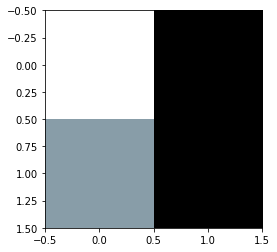

In [195]:
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)
imshow(confusion_matrix(y_test, y_pred), cmap='bone')
confusion_matrix(y_test, y_pred)
#True positive, False positive
#False negative, True negetive

In [144]:
clf3.score(X_test, y_test)

0.6013349514563107

In [145]:
clf3.score(X_train, y_train)

0.6326652707149267

In [169]:
feature_importance = pd.DataFrame(clf3.feature_importances_, columns = ['Importance'], index = df_all_short.columns)
feature_importance = feature_importance.rename(index={'Food_prot_v':'Food Protection', 
                                                      'Food_sou_v':'Food Source', 'Food_prep_v':'Food Preparation',
                                                     'Facility_v':'Facility Design Maintenance', 
                                                      'Vermin_v':'Vermin and Waste'})
feature_importance

,Importance
Food Protection,0.133945
Food Source,0.356935
Food Preparation,0.165726
Facility Design Maintenance,0.215187
Vermin and Waste,0.128208


In [148]:
# Train test interpretations
# https://datascience.stackexchange.com/questions/28426/train-accuracy-vs-test-accuracy-vs-confusion-matrix

### Graph export

In [161]:
# Tree from random forest
rforest_3 = clf3.fit(df_all_short.values, df_all_select["Incident"])
estimator0 = rforest_3.estimators_[0]
estimator1 = rforest_3.estimators_[1]
estimator2 = rforest_3.estimators_[2]
estimator3 = rforest_3.estimators_[3]
estimator4 = rforest_3.estimators_[4]
estimator5 = rforest_3.estimators_[5]
estimator6 = rforest_3.estimators_[6]
estimator7 = rforest_3.estimators_[7]
estimator8 = rforest_3.estimators_[8]
estimator9 = rforest_3.estimators_[9]

export_graphviz(estimator0, out_file='tree_rf_0_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator1, out_file='tree_rf_1_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator2, out_file='tree_rf_2_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator3, out_file='tree_rf_3_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator4, out_file='tree_rf_4_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator5, out_file='tree_rf_5_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator6, out_file='tree_rf_6_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator7, out_file='tree_rf_7_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator8, out_file='tree_rf_8_b.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator9, out_file='tree_rf_9_b.dot', 
                rounded = True, proportion = False, filled = True)


In [16]:
# https://gist.github.com/milesgrimshaw/5b1cee4e2b6acb1c215f
# http://milesgrimshaw.com/nyc-restaurant-database/

In [1]:
# Tree Visualization
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

In [ ]:
# https://stackoverflow.com/questions/27975069/how-to-filter-rows-containing-a-string-pattern-from-a-pandas-dataframe